In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline, interp1d
from scipy.special import erfc
import pandas as pd
from getdist import plots, MCSamples

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

settings={'mult_bias_correction_order':0,'smooth_scale_2D':0.2, 'smooth_scale_1D':0.2}
contours = [0.68,0.95]
linewidth = 2 

In [2]:
def prob_template_given_mag(fraction, kt, magnitude):
    """
    | Spectral type | Fraction | kt    |
    |---------------|----------|-------|
    | E/SO          | 0.35     | 0.147 |
    | Spirals       | 0.50     | 0.450 |
    | Irregulars    | 0.15     |       |
    """
    if magnitude>32.: magnitude = 32. + 1E-32
    if magnitude<20.: magnitude = 20. + 1E-32
        
    expterm = kt * (magnitude - 20.0)
    return fraction * np.exp(-expterm)

def prob_redshift_given_template_mag(redshift, magnitude, alpha, redshift_ref, kmt):
    """
    See table from Benitez (2000). 
    
    | Spectral type | alpha  | redshift reference | kmt    |
    |---------------|--------|--------------------|--------|
    | E/SO          | 2.465  | 0.431              | 0.0913 |
    | Spirals       | 1.806  | 0.390              | 0.0636 |
    | Irregulars    | 0.906  | 0.0626             | 0.123  |
    """
    if magnitude>32.: magnitude = 32. + 1E-32
    if magnitude<20.: magnitude = 20. + 1E-32

    zmt = redshift_ref + kmt * (magnitude - 20)
    probability = redshift**alpha * np.exp(- (redshift / zmt)**alpha)
    norm = np.trapz(probability, redshift)
    return probability / norm

def prob_redshift_given_mag(redshift, magnitude):

    p_temp_eso = prob_template_given_mag(0.35, 0.147, magnitude)
    p_temp_spi = prob_template_given_mag(0.50, 0.45, magnitude)
    p_temp_irr = 1 - (p_temp_eso + p_temp_spi)
        
    probability_eso = prob_redshift_given_template_mag(redshift, magnitude, 2.465, 0.431, 0.0913)
    probability_spi = prob_redshift_given_template_mag(redshift, magnitude, 1.806, 0.390, 0.0636)
    probability_irr = prob_redshift_given_template_mag(redshift, magnitude, 0.906, 0.0626, 0.123)

    probability = p_temp_eso * probability_eso + p_temp_spi * probability_spi + p_temp_irr * probability_irr
    probability = probability / np.trapz(probability, redshift)
    return probability

# Plot Distributions

In [3]:
# the fine bin for redshift 
z_grid_binsize = 0.001
z_grid_edges = np.arange(0.0, 3.0, z_grid_binsize)
z_grid = (z_grid_edges[1:] + z_grid_edges[:-1])/2.

# the magnitude
magnitude = 22.0 

In [4]:
p_temp_eso = prob_template_given_mag(0.35, 0.147, magnitude)
p_temp_spi = prob_template_given_mag(0.50, 0.45, magnitude)
p_temp_irr = 1 - (p_temp_eso + p_temp_spi)

In [5]:
probability_eso = prob_redshift_given_template_mag(z_grid, 22, 2.465, 0.431, 0.0913)
probability_spi = prob_redshift_given_template_mag(z_grid, 22, 1.806, 0.390, 0.0636)
probability_irr = prob_redshift_given_template_mag(z_grid, 22, 0.906, 0.0626, 0.123)
prob_z_given_mag = prob_redshift_given_mag(z_grid, 22)

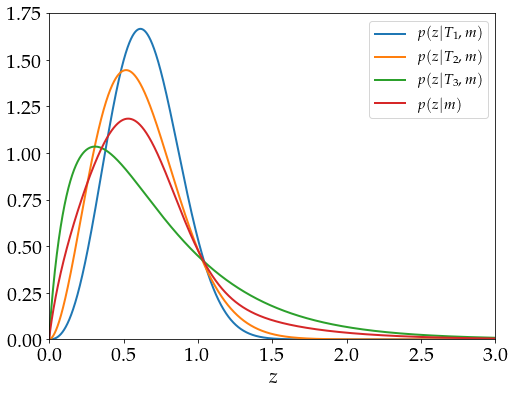

In [6]:
plt.figure(figsize = (8,6))
plt.plot(z_grid, probability_eso, lw = 2, label = r'$p(z|T_{1}, m)$')
plt.plot(z_grid, probability_spi, lw = 2, label = r'$p(z|T_{2}, m)$')
plt.plot(z_grid, probability_irr, lw = 2, label = r'$p(z|T_{3}, m)$')
plt.plot(z_grid, prob_z_given_mag, lw = 2, label = r'$p(z|m)$')
plt.xlim(min(z_grid)-0.001, max(z_grid)+0.002)
plt.ylim(0, 1.75)
plt.xlabel(r'$z$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

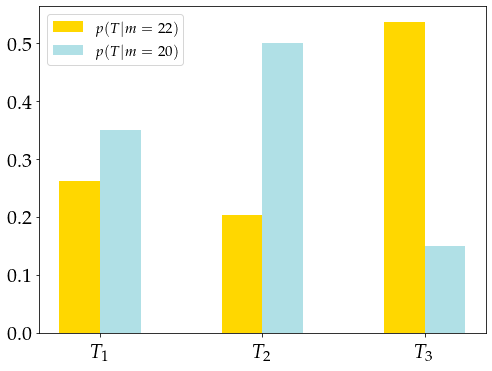

In [7]:
barWidth = 0.25
br1 = np.arange(3)
br2 = [x + barWidth for x in br1]

plt.figure(figsize=(8,6))
plt.bar(br1, [p_temp_eso, p_temp_spi, p_temp_irr], width = barWidth, label = r'$p(T|m=22)$', color = 'gold')
plt.bar(br2, [0.35, 0.50, 0.15], width = barWidth, label = r'$p(T|m=20)$',  color = 'powderblue')
plt.xticks([r + 0.5*barWidth for r in range(3)], [r'$T_{1}$', r'$T_{2}$', r'$T_{3}$'])
plt.tick_params(axis='x', labelsize=fontSize, pad=10)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Filters

In [8]:
def interpolate_filters(folder: str, fnames: list, nwave: int=1000):
    filters = dict()
    filters_int = dict()
    record_min = list()
    record_max = list()
    for file in fnames:
        filterband = np.loadtxt(f'{folder}/{file}')[:,[0,1]]
        wavelength = filterband[:,0]
        record_min.append(min(wavelength))
        record_max.append(max(wavelength))
        filters[file.split('.')[0]] = filterband
        
    minwave = min(record_min)
    maxwave = max(record_max)
    waveint = np.linspace(minwave, maxwave, nwave)
    
    for key, value in filters.items():
        func = interp1d(value[:,0], value[:,1], bounds_error=False, kind='linear',
                        fill_value=(value[:,1][0], value[:,1][-1]))
        ynew = func(waveint)
        filters_int[key] = ynew
    filters_int['wavelength'] = waveint
    
    return filters_int

In [9]:
filternames = ['u.dat', 'g.dat', 'r.dat', 'i.dat', 'z.dat']
filters_int = interpolate_filters('filters', filternames, 1000)

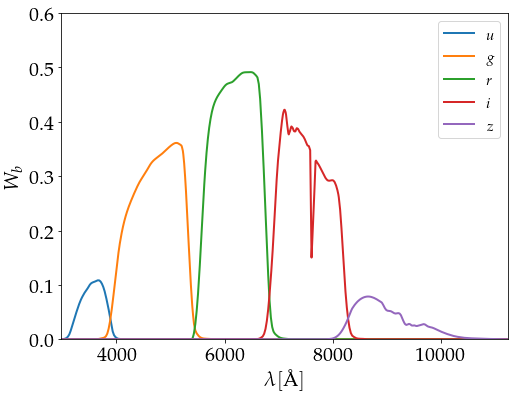

In [10]:
plt.figure(figsize = (8, 6))
plt.plot(filters_int['wavelength'], filters_int['u'], label = r'$u$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['g'], label = r'$g$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['r'], label = r'$r$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['i'], label = r'$i$', lw = 2)
plt.plot(filters_int['wavelength'], filters_int['z'], label = r'$z$', lw = 2)
plt.ylim(0.0, 0.6)
plt.xlim(min(filters_int['wavelength']), max(filters_int['wavelength']))
plt.xlabel(r'$\lambda [\textrm{\AA}]$', fontsize = fontSize)
plt.ylabel(r'$W_{b}$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Templates

In [11]:
def process_templates(folder, waverange: list, nwave: int = 1000, normwave=7E3):
    """
    Process the templates in such a way that they are normalised at wavelength=7000 angstrom. They are 
    also interpolated in the range of the wavelength of the filters, that is, between 2980.0 and 11230.0. 
    """
    waveint = np.linspace(waverange[0], waverange[1], nwave)
    templates = dict()
    seds = os.listdir('seds/')
    for f in seds:
        file = np.loadtxt(f'seds/{f}')
        wavelength = file[:, 0]
        sed = file[:,1] * file[:,0]**2
        norm_constant = np.interp(normwave, wavelength, sed)
        sed = sed / norm_constant
        func = interp1d(wavelength, sed, bounds_error=False, kind='linear', fill_value=(sed[0], sed[-1]))
        ynew = func(waveint)
        templates[f.split('.')[0]] = ynew
    templates['wavelength'] = waveint
    return templates

In [12]:
# filenames for the templates 
template_fnames = os.listdir('seds/')
templatenames = [f.split('.')[0] for f in template_fnames]

# ellipticals = ['El_B2004a.sed']
# spirals = ['Sbc_B2004a.sed','Scd_B2004a.sed']
# irregulars = ['Im_B2004a.sed','SB3_B2004a.sed','SB2_B2004a.sed', 'ssp_25Myr_z008.sed','ssp_5Myr_z008.sed']

# process templates 
waverange = (filters_int['wavelength'][0], filters_int['wavelength'][-1])
templates = process_templates('seds/', waverange, 1000, 7.5E3)

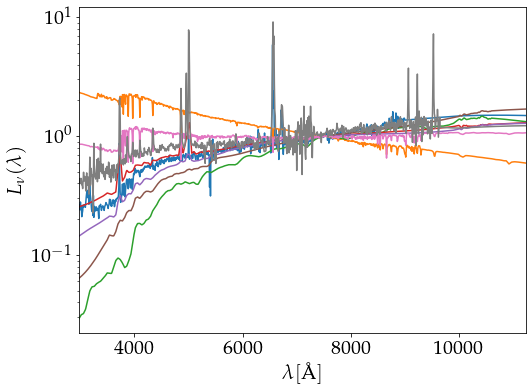

In [13]:
plt.figure(figsize=(8,6))
for fname in templatenames:
    plt.plot(templates['wavelength'], templates[fname])
plt.xlabel(r'$\lambda [\textrm{\AA}]$', fontsize = fontSize)
plt.ylabel(r'$L_{\nu}(\lambda)$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xlim(waverange[0], waverange[1])
plt.yscale('log')
plt.show()

# Example of Magnitude Distribution

In [14]:
def imagnitude_distribution(mgrid, alpha=15.0, beta = 2.0, maglim=24.0, offset = 1.0):
    probability = mgrid**alpha * np.exp(-(mgrid/(maglim - offset))**beta)
    normalisation = np.trapz(probability, mgrid)
    probability /= normalisation
    return probability 

def imagnitude_error_distribution(magnitudes, param_a = 4.56, param_b=1.0, param_k = 1.0, maglim=24.0, sigmadet = 5.0):
    teff = np.exp(param_a + param_b * (maglim - 21.0))
    flux = 10**(-0.4 * (magnitudes - 22.5))
    flim = 10**(-0.4 * (maglim-22.5))
    fnoise = (flim / sigmadet)**2 * param_k * teff - flim
    sigma_m = 2.5/np.log(10) * np.sqrt((1.0+fnoise/flux)/(flux * param_k * teff))
    return sigma_m

def draw_samples_one_dim(pdf, grid, nsamples):
    cdf = np.cumsum(pdf)
    cdf /= np.max(cdf)
    uniform = np.random.uniform(0, 1, nsamples)
    func = interp1d(cdf, grid, bounds_error=False)
    samples = func(uniform)
    return samples

def analytical_error_distribution(probability_imag, mgrid, maglim=24.0):
    detprob = np.copy(probability_imag)
    ind = (mgrid >= maglim - 0.4)
    detprob[ind] *= np.exp(-0.5*((mgrid[ind]- maglim + 0.4) / 0.2)**2)
    normalisation = np.trapz(detprob, mgrid)
    detprob /= normalisation
    return detprob

In [15]:
# grid for i magnitude
imag_grid = np.linspace(17, 26, num=1000)  

# distribution for the i magnitude.
p_imag = imagnitude_distribution(imag_grid)

In [16]:
# Large number of objects to be generated.
nobj = 100000
imags = draw_samples_one_dim(p_imag, imag_grid, nobj) # draw_mag(nobj, imag_grid, p_imag)
imagerrs = imagnitude_error_distribution(imags) # imag_err(imags, maglim) 
imagswitherr = imags + imagerrs*np.random.randn(nobj)

In [17]:
# Doing SNR cut - keep galaxies detected at 5 sigma only
ind = (1./imagerrs > 5.) 
imags_cut = imags[ind]
imagerrs_cut = imagerrs[ind]
imagswitherr_cut = imagswitherr[ind]

In [18]:
analytical_error = analytical_error_distribution(p_imag, imag_grid)

# Sample from $p(m_{i})$

In [19]:
NBINS = 30

Error distribution for the $i$ magnitude. 

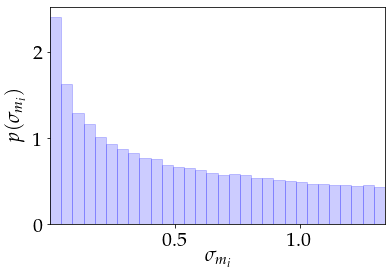

In [20]:
plt.figure()
plt.hist(imagerrs, density=True, bins=NBINS, edgecolor='b', color = 'b', alpha = 0.2)
plt.xlim(min(imagerrs), max(imagerrs))
plt.xlabel(r'$\sigma_{m_{i}}$', fontsize = fontSize)
plt.ylabel(r'$p(\sigma_{m_{i}})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.show()

Distribution for the $m_{i}$, with/without cut-off (SNR). 

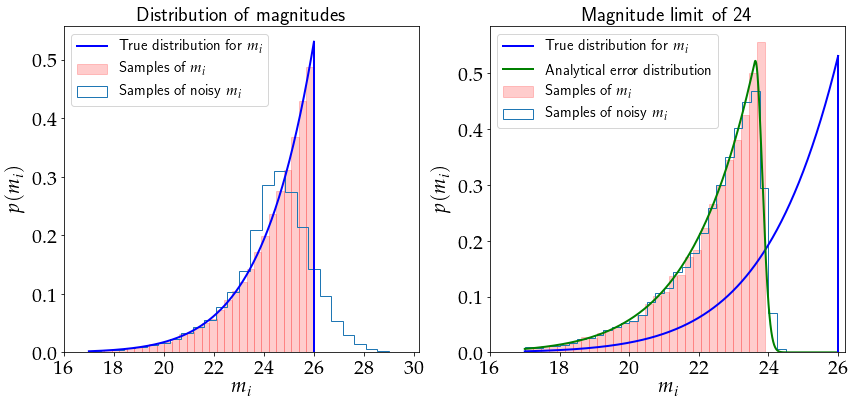

In [21]:
plt.figure(figsize = (14, 6))
plt.subplot(121)
plt.title('Distribution of magnitudes', fontsize=fontSize)
plt.plot(imag_grid, p_imag, lw = 2, c = 'b', label = 'True distribution for $m_{i}$')
plt.plot([imag_grid[-1]]*2, [0, p_imag[-1]], lw = 2, c = 'b')
plt.hist(imags, density = True, bins=NBINS, edgecolor='r', color = 'r', alpha = 0.2, label = 'Samples of $m_{i}$')
plt.hist(imagswitherr, density = True, histtype='step', bins=NBINS, label = 'Samples of noisy $m_{i}$')
plt.xlabel(r'$m_{i}$', fontsize = fontSize)
plt.ylabel(r'$p(m_{i})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xticks(np.arange(16, 30.2, 2))
plt.xlim(16, 30.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.subplot(122)
plt.title('Magnitude limit of 24', fontsize=fontSize)
plt.plot(imag_grid, p_imag, lw = 2, c = 'b', label = 'True distribution for $m_{i}$')
plt.plot(imag_grid, analytical_error, lw = 2, c = 'g', label = 'Analytical error distribution')
plt.plot([imag_grid[-1]]*2, [0, p_imag[-1]], lw = 2, c = 'b')
plt.hist(imags_cut, density = True, bins=NBINS, edgecolor='r', color = 'r', alpha = 0.2, label = 'Samples of $m_{i}$')
plt.hist(imagswitherr_cut, density = True, histtype='step', bins=NBINS, label = 'Samples of noisy $m_{i}$')
plt.xlabel(r'$m_{i}$', fontsize = fontSize)
plt.ylabel(r'$p(m_{i})$', fontsize = fontSize)
plt.tick_params(axis='x', labelsize=fontSize)
plt.tick_params(axis='y', labelsize=fontSize)
plt.xticks(np.arange(16, 26.2, 2))
plt.xlim(16, 26.2)
plt.legend(loc = 'best',prop={'family':'sans-serif', 'size':15})
plt.show()

# Sample redshift

In [22]:
def pdf_redshift(magnitude_samples, redshift, template_ref: str = 'eso'):
    
    assert template_ref in ['eso', 'spi', 'irr', 'marg'], 'template reference should be one of eso, spi, irr, marg'
    
    if template_ref == 'eso':
        pdf = prob_redshift_given_template_mag(redshift, magnitude_samples, 2.465, 0.431, 0.0913)
    elif template_ref == 'spi':
        pdf = prob_redshift_given_template_mag(redshift, magnitude_samples, 1.806, 0.390, 0.0636)
    elif template_ref == 'irr':
        pdf = prob_redshift_given_template_mag(redshift, magnitude_samples, 0.906, 0.0626, 0.123)
    else:
        pdf = prob_redshift_given_mag(redshift, magnitude_samples)
    return pdf

def sample_redshift(magnitude_samples, redshift, template_ref: str = 'eso'):
    pdf = pdf_redshift(magnitude_samples, redshift, template_ref)
    sample = draw_samples_one_dim(pdf, redshift, 1)
    return sample

In [23]:
nobj_cut = 10000 # len(imags_cut)

In [24]:
%%time
redshift_eso = np.array([pdf_redshift(imags_cut[i], z_grid, 'eso') for i in range(nobj_cut)])
redshift_spi = np.array([pdf_redshift(imags_cut[i], z_grid, 'spi') for i in range(nobj_cut)])
redshift_irr = np.array([pdf_redshift(imags_cut[i], z_grid, 'irr') for i in range(nobj_cut)])
redshift_marg = np.array([pdf_redshift(imags_cut[i], z_grid, 'marg') for i in range(nobj_cut)])

CPU times: user 23.3 s, sys: 242 ms, total: 23.5 s
Wall time: 23.6 s


In [25]:
%%time
sample_redshift_eso = np.array([sample_redshift(imags_cut[0], z_grid, 'eso') for i in range(nobj_cut)]).reshape(-1)
sample_redshift_spi = np.array([sample_redshift(imags_cut[0], z_grid, 'spi') for i in range(nobj_cut)]).reshape(-1)
sample_redshift_irr = np.array([sample_redshift(imags_cut[0], z_grid, 'irr') for i in range(nobj_cut)]).reshape(-1)
sample_redshift_marg = np.array([sample_redshift(imags_cut[0], z_grid, 'marg') for i in range(nobj_cut)]).reshape(-1)

CPU times: user 27.8 s, sys: 0 ns, total: 27.8 s
Wall time: 27.8 s


In [26]:
nselected = 1000

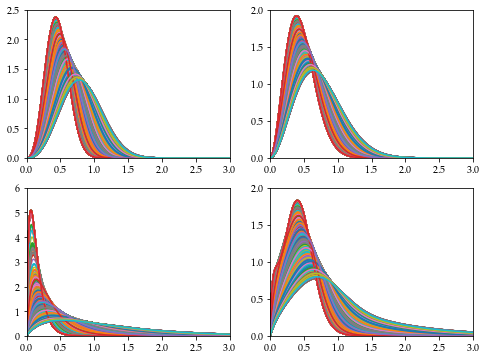

In [27]:
plt.figure(figsize = (8,6))
plt.subplot(221)
plt.plot(z_grid, redshift_eso[0:nselected].T)
plt.xlim(0, 3.0)
plt.ylim(0, 2.5)
plt.subplot(222)
plt.plot(z_grid, redshift_spi[0:nselected].T)
plt.xlim(0, 3.0)
plt.ylim(0, 2.0)
plt.subplot(223)
plt.plot(z_grid, redshift_irr[0:nselected].T)
plt.xlim(0, 3.0)
plt.ylim(0, 6.0)
plt.subplot(224)
plt.plot(z_grid, redshift_marg[0:nselected].T)
plt.xlim(0, 3.0)
plt.ylim(0, 2.0)
plt.show()

In [28]:
data_eso = np.array([sample_redshift_eso, imags_cut[0:nobj_cut]]).T
data_spi = np.array([sample_redshift_spi, imags_cut[0:nobj_cut]]).T
data_irr = np.array([sample_redshift_irr, imags_cut[0:nobj_cut]]).T
data_marg = np.array([sample_redshift_marg, imags_cut[0:nobj_cut]]).T

In [29]:
def generate_2d_plot(samples, name = 'E/SO'):
    ndim = samples.shape[1]
    names = ["x%s"%i for i in range(ndim)]
    labels =  [r'$z$', r'$m_{i}$']
    samps = MCSamples(samples=samples, names = names, labels = labels, 
                          ranges={'x0':(0.0, None)}, settings=settings) 
    g = plots.get_single_plotter(width_inch=4, ratio=1)
    g.plot_2d(samps, 'x0', 'x1', filled=True)
    g.add_legend([name], colored_text=True, legend_loc='lower right');
    plt.show()

Removed no burn in


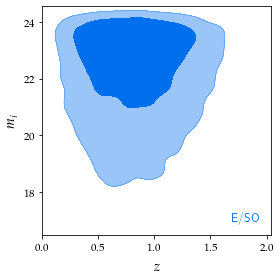

In [30]:
generate_2d_plot(data_eso, name = 'E/SO')

Removed no burn in


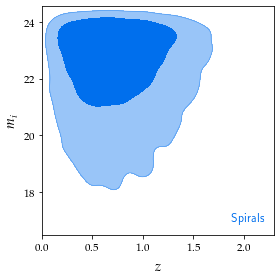

In [31]:
generate_2d_plot(data_spi, name = 'Spirals')

Removed no burn in


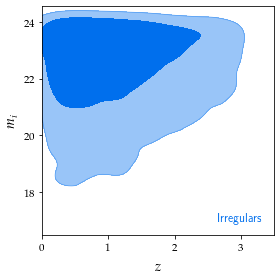

In [32]:
generate_2d_plot(data_irr, name = 'Irregulars')

Removed no burn in


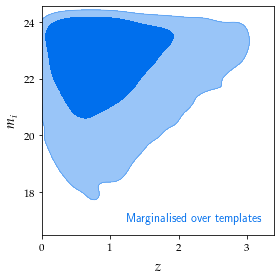

In [33]:
generate_2d_plot(data_marg, name = 'Marginalised over templates')